<a href="https://colab.research.google.com/github/DonErnesto/masterclassSFI_2021/blob/main/notebooks/CreditCardUnsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Fraud Detection


**Introduction**


The purpose of this Jupyter notebook is to take you through several unsupervised outlier detection algorithms, and show their value for the purpose of fraud detection. The completely different approach compared to the supervised case, is that we assume we have insufficient labels to recognize fraud patterns, as is often the case in fraud detection as fraud events are typically very rare. In applying an outlier detection for fraud detection, we hypothesize that payment patterns that are "untypical" (outliers) are more likely to be fraudulent.  


Generally, whenever an unsupervised approach is chosen, there are no labels available; neither for algorithm optimization, nor for comparison or validation. For this masterclass, we do use a labeled dataset, which will only be used at the very end, to get a feeling of how the various algorithms perform and compare. 


The data was taken from https://www.kaggle.com/mlg-ulb/creditcardfraud, and downsampled for the purpose of this masterclass. 


- Add also here the ROC and AP curves


In [1]:
## Data import from Github
import os
if not os.path.exists('X_unsupervised.csv.zip'):
    !curl -O https://raw.githubusercontent.com/DonErnesto/masterclassSFI_2021/main/data/X_unsupervised.csv.zip

We will be using the "pandas" package for data handling and manipulation, and later "scikit-learn" (imported with "sklearn") for various outlier detection algorithms. 

In [2]:
## Package import: pandas for data handling and manipulation
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

# A small hack: "monkey-patching" the DataFrame class to add column-wise normalization as a method
def normalize_columns(self,):
    return (self - self.mean()) / self.std()

pd.DataFrame.normalize_columns = normalize_columns

Next, we will load the data in a so-called DataFrame (a pandas object), and inspect it by plotting the N-top rows

In [3]:
X = pd.read_csv('X_unsupervised.csv.zip')
# .head() returns a DataFrame, that consists of the first N (default: N=5) rows 
# of the DataFrame it is applied on
X.head() 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-0.7200,0.1262,-0.2262,-0.7573,0.2147,0.3516,1.4450,-0.6830,-0.5464,...,-0.0378,-0.3525,0.6494,-1.0810,-0.39230,-0.14340,-0.6920,0.8833,-0.210200,5.46
1,0.0,-1.4110,0.3550,-1.0470,0.9326,-1.4970,0.3967,-1.4750,1.0490,-1.7940,...,-0.4248,-0.3650,0.9517,0.5230,0.10830,-0.13880,2.5820,-0.3887,0.009520,52.53
2,1.0,0.4917,-1.4040,1.0270,0.9020,-0.7363,-0.3188,0.2524,-2.0230,0.4365,...,-1.0470,-0.7330,-0.1733,1.0900,0.56400,-0.55700,-0.0928,1.5810,-0.005043,22.48
3,1.0,-1.2430,0.2893,-0.7030,0.7340,-0.1942,0.4436,0.3428,-0.1865,-0.1589,...,-2.2770,0.4973,0.7670,-0.3362,-0.00434,0.02498,0.7993,0.4668,0.074460,15.00
4,2.0,0.2642,0.7010,1.5230,-1.4570,-0.3555,1.1720,-0.7266,-1.4990,-0.5590,...,-1.3620,0.5350,-2.4450,1.5910,0.87200,-0.67870,0.9653,0.1272,0.132400,237.00


The data describes credit card transactions, one transaction per row. 

As you may notice, all features are numeric. All Vx features are the result of a mathematical operation called PCA. In reality, we have to deal often with non-numerical (for instance, categorical data), that requires some effort to make it numerical and suitable for the mathematical models we work with. 

The pre-fabricated data thus saves us considerable time. 

Let us first determine the dimensions of the DataFrame (note that the first dimension goes along the rows, the second along columns):

## Assignment: Defining a homemade outlier score

Generate an array with outlier scores based on your own hand-made logic. Store the outlier predictions in a pandas Series with the name "homemade_outlier_scores", using the examples below. 


**Question:**

Below, there are several options to create a hand-crafted outlier score. 

Which one would you chose, and why? Uncomment your preference, to assign the outcome to the variable 'homemade_outlier_scores'. If you see a better solution, you are free to implement that. 

The various methods that are used on the DataFrame are:
- .abs() This method converts all values to their absolute (and does not change the size of the DataFrame)
- .drop(columns=...) This method returns the DataFrame with the indicated columns (may be a string or a list of strings) removed
- .max(axis=1) This method, when executed with axis=1, sums over all columns
- .mean(axis=1) 

In [4]:
# Some examples to make an outlier score below. Uncomment (remove the "#") to execute it.

# homemade_outlier_scores = X.drop(columns='Time').abs().max(axis=1)
# homemade_outlier_scores = (X.normalize_columns()**2).mean(axis=1)
# homemade_outlier_scores = X['Amount']
# homemade_outlier_scores = X.drop(columns='Time').abs().max(axis=1) # .drop() returns the cropped dataframe



In [5]:
# To verify the shape, add .shape to the dataframe and look at the output. What shape should it be?
# homemade_outlier_scores.shape

# Outlier algorithms

Go to the section of the outlier algorithm assigned to you or chosen by you to generate your scores. 
First run the cell below for important imports, and to get rid of the "Time" column. 


In [6]:
# from sklearn.neighbors import LocalOutlierFactor
# !pip install seaborn==0.11.1 # Needed for plotting
# !pip install tensorflow
!pip install pyod
import numpy as np
from sklearn.covariance import EmpiricalCovariance
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from pyod.models.auto_encoder import AutoEncoder
from sklearn.preprocessing import MinMaxScaler

X = X.drop(columns='Time')

You should consider upgrading via the '/Users/ernstoldenhof/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


## Mahalanobis Distance

The Mahalanobis distance is a generalization of distance (measured in standard deviations) to a multivariate normal distribution. The assumption being made is thus that the data is normally distributed, and that outliers are located further away than most of the inliers. 

In the cells below: 
- Create an EmpiricalCovariance object with the correct parameters (find out which ones)
- Fit the data to this model
- Assign the scores to "mah_outlier_scores", using the method "mahalanobis"

Can the outcome of this method be directly used as an outlier score?

In [7]:
?EmpiricalCovariance

In [8]:
cov = EmpiricalCovariance()
cov.fit(X)
mah_outlier_scores = cov.mahalanobis(X)

**Question**: in which situation is the Mahalonobis-distance equal to do a simple, column-wise mean of squared values? 

## Gaussian Mixture

The Gaussian Mixture assumes the data consists of one or multiple "blobs" of clusters with some normal distribution (NB: with a co-variance matrix constrained to be spherical, diagonal or non-constrained - full). 
After fitting, the method .score_samples() returns some probability measure (probability density of the point within the gaussian mixture distribution). 

In the cells below, 

- Create a GaussianMixture object with sensible parameters 
- Fit the object to the data
- Get scores for the individual data points using .score_samples() 

In [9]:
?GaussianMixture

In [10]:
gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=1) 
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=1, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [11]:
gmm_scores = gmm.score_samples(X)

In [12]:
?GaussianMixture

**Question**: The .score_samples method returns a probability. Can the scores be used as they are or do they need to be modified? Reflect this in your calculation. 

## Nearest neighbours

The family ofnearest neighbours-based algorithms looks at the immediate "neighbour" in terms of nearest points. 
If a point is far-removed from its neighbours, it may be considered untypical. The distance may however be determined in several different ways. 

In the cells below: 
- Create an EmpiricalCovariance object with the correct parameters (find out which ones)
- Fit the data to this model
- Assign the scores to "mah_outlier_scores", using the method "mahalonobis"

Let's create a NearestNeighbors object, and use that. First, we may want to read some documentation regarding the NearestNeighbors class:

In [13]:
?NearestNeighbors

In [14]:
nn = NearestNeighbors(n_neighbors=50)
nn.fit(X)
distances_to_neighbors = nn.kneighbors()[0]

The "heavy lifting" was done by the kneighbors() method. 
It returns the distances to the first N points, and the index of the nearest point 


As a final step, reduce the distance matrix (size: N points x N neighbours) to scores, one per point (row). 
Use an appropiate numpy function (ideas are: mean, median, min, max)

In [15]:
knn_mean_outlier_scores = np.mean(distances_to_neighbors, axis=1)

**Question**: what is an interpretation (say when n_neighbours is 11) for the

- median
- min
- max

distance to the n_neighbours?

## Isolation Forest algorithm

The isolation forest algorithm measures how difficult it is to isolate a point from the rest of the data, using a random splitting algorithm many times. We want to have 1000 estimators (trees), and each estimator to be based on a sample of 1024 points

In the cells below: 
- Create an IsolationForest object with the correct parameters
- Fit the IsolationForest object with the data
- Get the scores using .score_samples()


In [16]:
?IsolationForest

In [17]:
iforest = IsolationForest(n_estimators=100, max_samples=1024)
iforest.fit(X)


IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples=1024, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

The score as returned by score_samples() is a measure for the number of needed splits to isolate a point. 

**Question:** Is a high score or a low score an indication for a point being an outlier? 
Reflect this in your score calculation. 


In [18]:
iforest_outlier_scores = iforest.score_samples(X)

##  Autoencoder

Autoencoders are a special type of neural networks, that are trained to effectively compress and decompress a signal. The idea behind using these networks for outlier detection, is that the neural network is expected to handle "typical" datapoints well, whereas it will struggle with outliers. 

We use the pyod AutoEncoder class, because this way we don't have to define all details of the neural network architecture, but can specify the main parameters. 



In [19]:
?AutoEncoder

In [20]:
X_scaled = MinMaxScaler().fit_transform(X)
clf = AutoEncoder(
    hidden_neurons=[10, 5, 10], # Choose bottleneck here!
    hidden_activation='elu',
    output_activation='sigmoid', # Choose an activation ('linear', 'sigmoid', 'relu', 'elu' are some possibilities)
    optimizer='adam',
    epochs=10,
    batch_size=16,
    dropout_rate=0.0, #may not be needed here
    l2_regularizer=0.0,
    validation_size=0.1,
    preprocessing=False, #NB: this uses sklearn's StandardScaler
    verbose=1,
    random_state=1,
)

In [21]:
clf.fit(X_scaled)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 29)                870       
_________________________________________________________________
dropout (Dropout)            (None, 29)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                870       
_________________________________________________________________
dropout_1 (Dropout)          (None, 29)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                300       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5

AutoEncoder(batch_size=16, contamination=0.1, dropout_rate=0.0, epochs=10,
      hidden_activation='elu', hidden_neurons=[10, 5, 10],
      l2_regularizer=0.0,
      loss=<function mean_squared_error at 0x7f86fbcc0d40>,
      optimizer='adam', output_activation='sigmoid', preprocessing=False,
      random_state=1, validation_size=0.1, verbose=1)

In [22]:
?clf.decision_scores_

In [23]:
autoenc_outlier_scores = clf.decision_scores_

**Question**: Why do you think we had to scale the data with a MinMaxScaler?

# Plot and compare results

In the next section, you will compare how your algorithm did against your "home-made" algorithm, using the labels (ground-truth: is a point an outlier or not? In this case: is a transaction fraudulent or not?). 
Note that this information is usually not available for those problems where we decide to use outlier detection.


Look carefully at the plots and assess their meaning. 



In [24]:
# Get the labels, and a helper module
!curl -O https://raw.githubusercontent.com/DonErnesto/masterclassSFI_2021/main/data/y_unsupervised.csv.zip
!curl -O https://raw.githubusercontent.com/DonErnesto/masterclassSFI_2021/main/ml_utils.py
y = pd.read_csv('y_unsupervised.csv.zip')['Class']


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   418  100   418    0     0   1255      0 --:--:-- --:--:-- --:--:--  1251
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16469  100 16469    0     0  48296      0 --:--:-- --:--:-- --:--:-- 48296


In [25]:
from ml_utils import plot_top_N, plot_conditional_distribution

### Conditional distributions of the scores, and the AUC metrics

(NB: only plot your "homemade" score and your own algorithm. 

In [26]:
# _ = plot_outlier_scores(y.values, np.log1p(homemade_outlier_scores), title='Homemade: ')

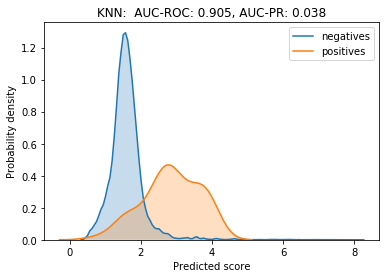

In [27]:
_ = plot_conditional_distribution(y.values, np.log1p(knn_mean_outlier_scores), title='KNN: ')

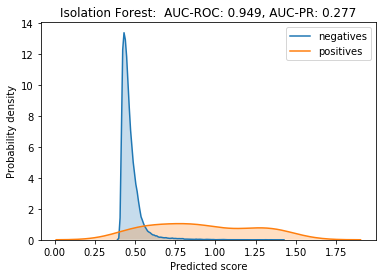

In [43]:
_ = plot_conditional_distribution(y.values, -np.log1p(iforest_outlier_scores), title='Isolation Forest: ')

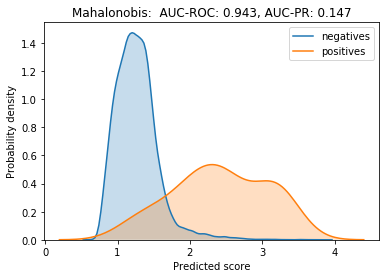

In [44]:
_ = plot_conditional_distribution(y.values, np.log10(mah_outlier_scores), title='Mahalonobis: ')

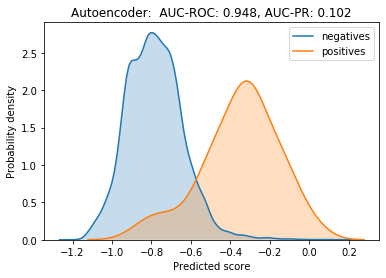

In [45]:
_ = plot_conditional_distribution(y.values, np.log10(autoenc_outlier_scores), title='Autoencoder: ')

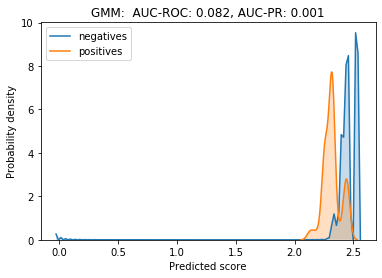

In [46]:
_ = plot_conditional_distribution(y.values, np.log10(gmm_scores - np.min(gmm_scores) + 1), title='GMM: ')

### Precision@top-N

In [47]:
# _ = plot_top_N(y_true=y, scores=homemade_outlier_scores, N=100)

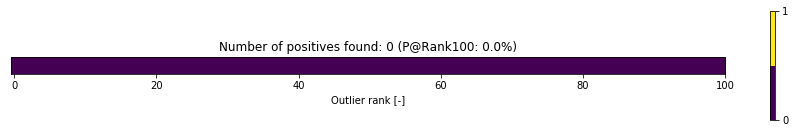

In [36]:
_ = plot_top_N(y_true=y, scores=knn_mean_outlier_scores, N=100)

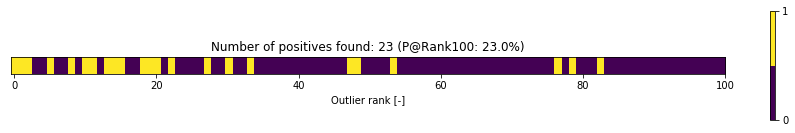

In [48]:
_ = plot_top_N(y_true=y, scores=-iforest_outlier_scores, N=100)

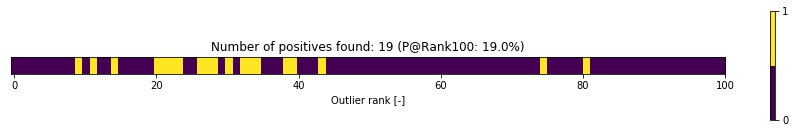

In [38]:
_ = plot_top_N(y_true=y, scores=mah_outlier_scores, N=100)

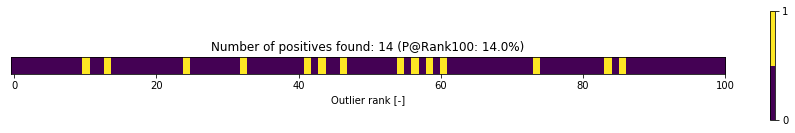

In [41]:
_ = plot_top_N(y_true=y, scores=autoenc_outlier_scores, N=100)

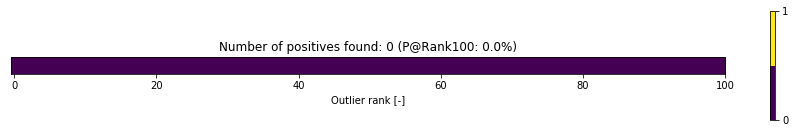

In [42]:
_ = plot_top_N(y_true=y, scores=gmm_scores, N=100)

**Question:** based on the number of positives, what precision do you expect when randomly guessing?

# Discussion



- How did you construct your home-made outlier model?
- How did it perform?
- What choices did you make for the outlier algorithm, if any, and why?
- Answers to the questions
